# 训练及测试
本笔记本将调用hw1/hw2以作出训练结果，亦可直接导出训练代码供使用。

首先，引入必要的依赖。

In [1]:
import cv2, matplotlib, scipy.ndimage
import numpy as np
import numpy.linalg as npMat
import matplotlib.pyplot as plt

import sys, os, time

import hw1, hw2

In [2]:
datasetConfig = {1: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10,
    11: 10, 12: 10, 13: 10, 15: 10, 16: 10, 17: 10, 18: 10, 22: 10, 23: 10,
    24: 10, 25: 10, 26: 10, 27: 10}

def read_from_dataset(hw1Var = 1, hw2Var = 1) -> list:
    '''This function implements read process, and process data with colorspace transform and filter.

    hw1Var 0=rgb, 1=weighted_mean_grey, 2=mean_grey, 3=max_grey

    hw2Var 0=no_change, 1=median_filter, 2=mean_filter(3*3), 3=gaussian_filter(3*3, 1.5)

    ret list(np.array)

    in case of 
    '''
    imReturn = []
    imShapeReturn = []
    for i, jlim in datasetConfig.items():
        imAll = None
        for j in range(1, jlim + 1):
            try:
                imFile = './dataset/s{}/s{}_{}.jpg'.format(i, i, j)
                imMatrix = cv2.imread(imFile)
                imMatrix = hw1.colorSpaceMatrix(BGR = imMatrix).space[hw1Var] # default: Convert to Grey with weighted mean.
                imMatrix = hw2.hw2Config[hw2Var](imMatrix) # default: With the process of Median Filter
                if isinstance(imAll, np.ndarray):
                    try:
                        imAll = np.append(imAll, [imMatrix], axis=0)
                    except ValueError:
                        print("[INFO] Append Error when i = {}, j = {}.".format(i, j)) # e.g.image's height and width isn't identical to the first one.
                else:
                    imAll = np.array([imMatrix])
            except Exception as e:
                print("[INFO] {} Error when i = {}, j = {}".format(e, i, j))
        # TIP not implemented in matlab
        imShapeReturn.append([imAll.shape[1], imAll.shape[2]])
        imAll.resize((imAll.shape[0], imAll.shape[1] * imAll.shape[2])) # shrink dimension, see doc for reasons
        imReturn.append(imAll)
    return imReturn, imShapeReturn

In [3]:
%timeit read_from_dataset()
im, imShape = read_from_dataset()
print(imShape)

16.6 s ± 817 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[[600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400], [600, 400]]


## 降维

PCA 的核心步骤：计算主成分（特征值更大的特征向量），然后通过矩阵相乘 $P \cdot A$ 得 $Q$ 。

其中阐述原理：方便你的方差计算、协方差计算，so作中心化 / 零均值化。注意不是归一化。

补充分析：主成分贡献率TODO

配图：特征向量即可。但第一个特征向量似乎有点特殊。

因为数据规模过大，无法通过数据验证，由优化算法得出来的特征向量与真实特征向量组的差距。

目前基于 https://www.cnblogs.com/mickeyyang/p/13262472.html 实现。

[(10, 240000), 600, 400]: [9.63369109e+09 7.80130075e+08 5.21959173e+08 3.02699649e+08
 2.87405989e+08 2.23630935e+08 1.76223130e+08 1.13302116e+08
 6.43750279e+07 7.67929798e+07]


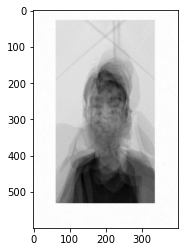

In [4]:
def pca(imageFeature) -> np.ndarray:
    matMean = imageFeature - np.tile(imageFeature.mean(1), (imageFeature.shape[1], 1)).T # TIP not implemented in matlab
    # matOne = imageFeature / np.linalg.norm(imageFeature.mean(1), axis = 0) # TIP not implemented in matlab
    # matMean = matMean.astype(np.uint8)
    # matCovaiance = np.dot(matMean.T, matMean) # still too large to calculate
    matMiddle = np.dot(matMean, matMean.T) # only after zero-mean.
    eigValue, eigPreVector = npMat.eig(matMiddle) # already sorted by eigValue, already normalization.
    # print(eigValue, eigPreVector)
    eigVector = np.dot(imageFeature.T, eigPreVector) / eigValue
    eigNormalizedVector = eigVector / npMat.norm(eigVector, axis = 0)
    # print(matMean, eigValue, eigPreVector, eigVector)
    processMat = np.dot(imageFeature, eigNormalizedVector)
    return eigValue, eigNormalizedVector, processMat

# As a pre dataset test
for i in [15]:
    print(str([im[i].shape] + imShape[i]) + ": ", end='')
    eigValue, eigNormalizedVector, processMatrix = pca(im[i])
    print(eigValue)
    temp = (eigNormalizedVector[:, 0]).reshape((imShape[i][0], imShape[i][1]))
    plt.imshow(temp, cmap = plt.get_cmap('Greys'))

In [5]:
imageFeature = np.reshape(im, (len(im) * im[0].shape[0], im[0].shape[1]))
%timeit pca(imageFeature)
eigValue, eigNormalizedVector, processMatrix = pca(imageFeature)
print(eigValue)

6.88 s ± 746 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[6.98192652e+10 2.60778241e+10 1.88450926e+10 1.14640898e+10
 8.76311279e+09 6.38587448e+09 4.75781282e+09 4.27535384e+09
 3.84574506e+09 3.01718116e+09 2.75974039e+09 2.64283108e+09
 2.46117285e+09 2.06765463e+09 1.82081856e+09 1.72482012e+09
 1.64140366e+09 1.50220675e+09 1.40456300e+09 1.27243713e+09
 1.21804916e+09 1.20443424e+09 1.13573957e+09 1.05193447e+09
 9.46655049e+08 9.31672027e+08 9.01123820e+08 8.67441009e+08
 8.30560032e+08 7.79223673e+08 7.18697316e+08 6.79252768e+08
 6.59838488e+08 6.46982350e+08 6.25578872e+08 5.81233460e+08
 5.78062307e+08 5.65730614e+08 5.56574927e+08 5.31295648e+08
 5.10591156e+08 4.96221581e+08 4.60592596e+08 4.52022516e+08
 4.48190954e+08 4.29095013e+08 4.18830710e+08 4.11200225e+08
 3.98175976e+08 3.84342989e+08 3.69184747e+08 3.56161554e+08
 3.56679621e+08 3.71825935e-08 3.44665546e+08 3.37657060e+08
 3.25145158e+08 3.20323291e+08 3.17491942e+08 3.06849951e+08
 3.02057776e+08 2.

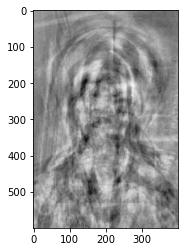

In [6]:
np.savez("train.npz", eVal = eigValue, eNorVec = eigNormalizedVector, pMat = processMatrix, utils = 
    [[idPack[0], 10 * (count0 + 1), imShape[0][0], imShape[0][1]] for count0, idPack in enumerate(datasetConfig.items())]
    )
temp = (eigNormalizedVector[:, 60]).reshape((imShape[0][0], imShape[0][1]))
plt.imshow(temp, cmap = plt.get_cmap('Greys'))